In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from scipy.io import arff
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, roc_auc_score 
from sklearn.metrics import f1_score, average_precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import graphviz
from sklearn.tree import export_graphviz

## Obesity Levels

In [5]:
# Cargamos el dataset (ajusta la ruta si es necesario)

df = pd.read_csv("Obesity_Levels/ObesityDataSet.csv")

# Revisamos las primeras filas del dataset
display(df.head())
print("Valores faltantes: ", df.isna().sum().sum())

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Valores faltantes:  0


In [6]:
# Codificación de las variables categóricas
le = LabelEncoder()
categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

label_encoder = LabelEncoder()
df['NObeyesdad'] = label_encoder.fit_transform(df['NObeyesdad'])

display(df)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,2,0,2.000000,0,0.000000,1.000000,3,3,1
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,2,1,3.000000,1,3.000000,0.000000,2,3,1
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,2,0,2.000000,0,2.000000,1.000000,1,3,1
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,2,0,2.000000,0,2.000000,0.000000,1,4,5
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,2,0,2.000000,0,0.000000,0.000000,2,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,2,0,1.728139,0,1.676269,0.906247,2,3,4
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,2,0,2.005130,0,1.341390,0.599270,2,3,4
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,2,0,2.054193,0,1.414209,0.646288,2,3,4
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,2,0,2.852339,0,1.139107,0.586035,2,3,4


In [8]:
# Separar las características y la variable objetivo
y = df['NObeyesdad']
X = df.drop(columns=['NObeyesdad'])  # NObeyesdad es la variable de nivel de obesidad

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar columnas numéricas
NUMERIC_FEATURES = X_train.select_dtypes(include=['float64', 'int64']).columns

# Crear el pipeline para las columnas numéricas
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

# Ajustar el pipeline solo con los datos de entrenamiento
numeric_pipe.fit(X_train[NUMERIC_FEATURES])

# Transformar los datos de entrenamiento y prueba
X_train[NUMERIC_FEATURES] = numeric_pipe.transform(X_train[NUMERIC_FEATURES])
X_test[NUMERIC_FEATURES] = numeric_pipe.transform(X_test[NUMERIC_FEATURES])

# Entrenar el modelo de árbol de decisión
dtc = DecisionTreeClassifier(random_state=123)

# Definir los hiperparámetros para GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función de criterio
    'max_depth': range(2,11),  # Profundidad máxima del árbol
    'min_samples_split': range(2,11),  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': range(1,5)    # Mínimo de muestras en una hoja
}

# Crear GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=5,                # Número de divisiones para la validación cruzada
    verbose=1           # Mostrar progreso
)

start_time = time.time()
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Entrenamiento del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_


training_time = time.time() - start_time

# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.2f segundos" % training_time)

# Usar el mejor modelo encontrado por GridSearch
best_model = grid_search.best_estimator_


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2}
Tiempo de entrenamiento: 68.20 segundos


In [16]:
y_pred = best_model.predict(X_test)

# Métricas
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Accuracy: ", round(accuracy_score(y_test, y_pred),4)*100)
test_f1 = f1_score(y_test, y_pred, average='weighted')
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test F1-score: {test_f1*100:.2f}")
print(f"Test Precision: {test_precision*100:.2f}")
print(f"Test Recall: {test_recall*100:.2f}")



Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.93      0.90      0.92        62
           2       0.95      0.97      0.96        78
           3       0.97      0.97      0.97        58
           4       1.00      1.00      1.00        63
           5       0.91      0.93      0.92        56
           6       0.98      0.92      0.95        50

    accuracy                           0.95       423
   macro avg       0.95      0.95      0.95       423
weighted avg       0.95      0.95      0.95       423

Accuracy:  95.27
Test F1-score: 95.27
Test Precision: 95.30
Test Recall: 95.27


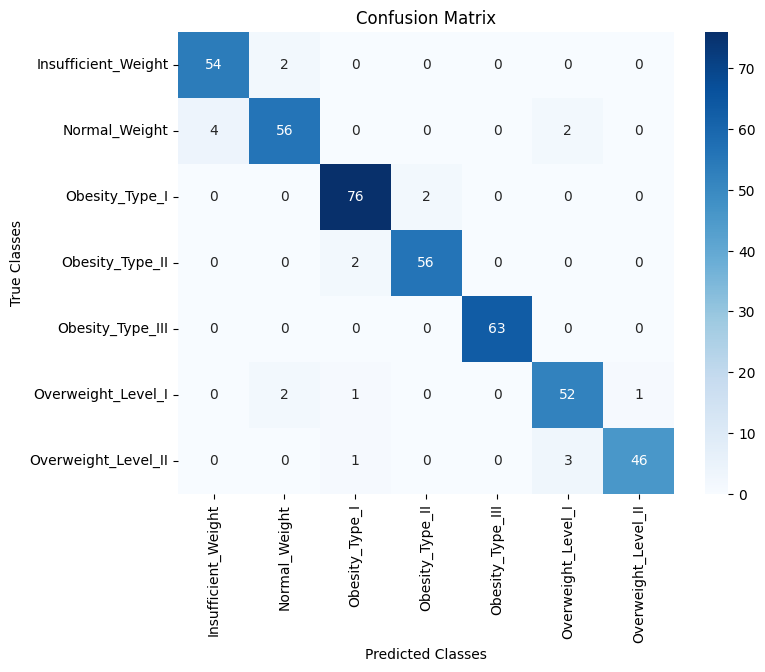

In [17]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()

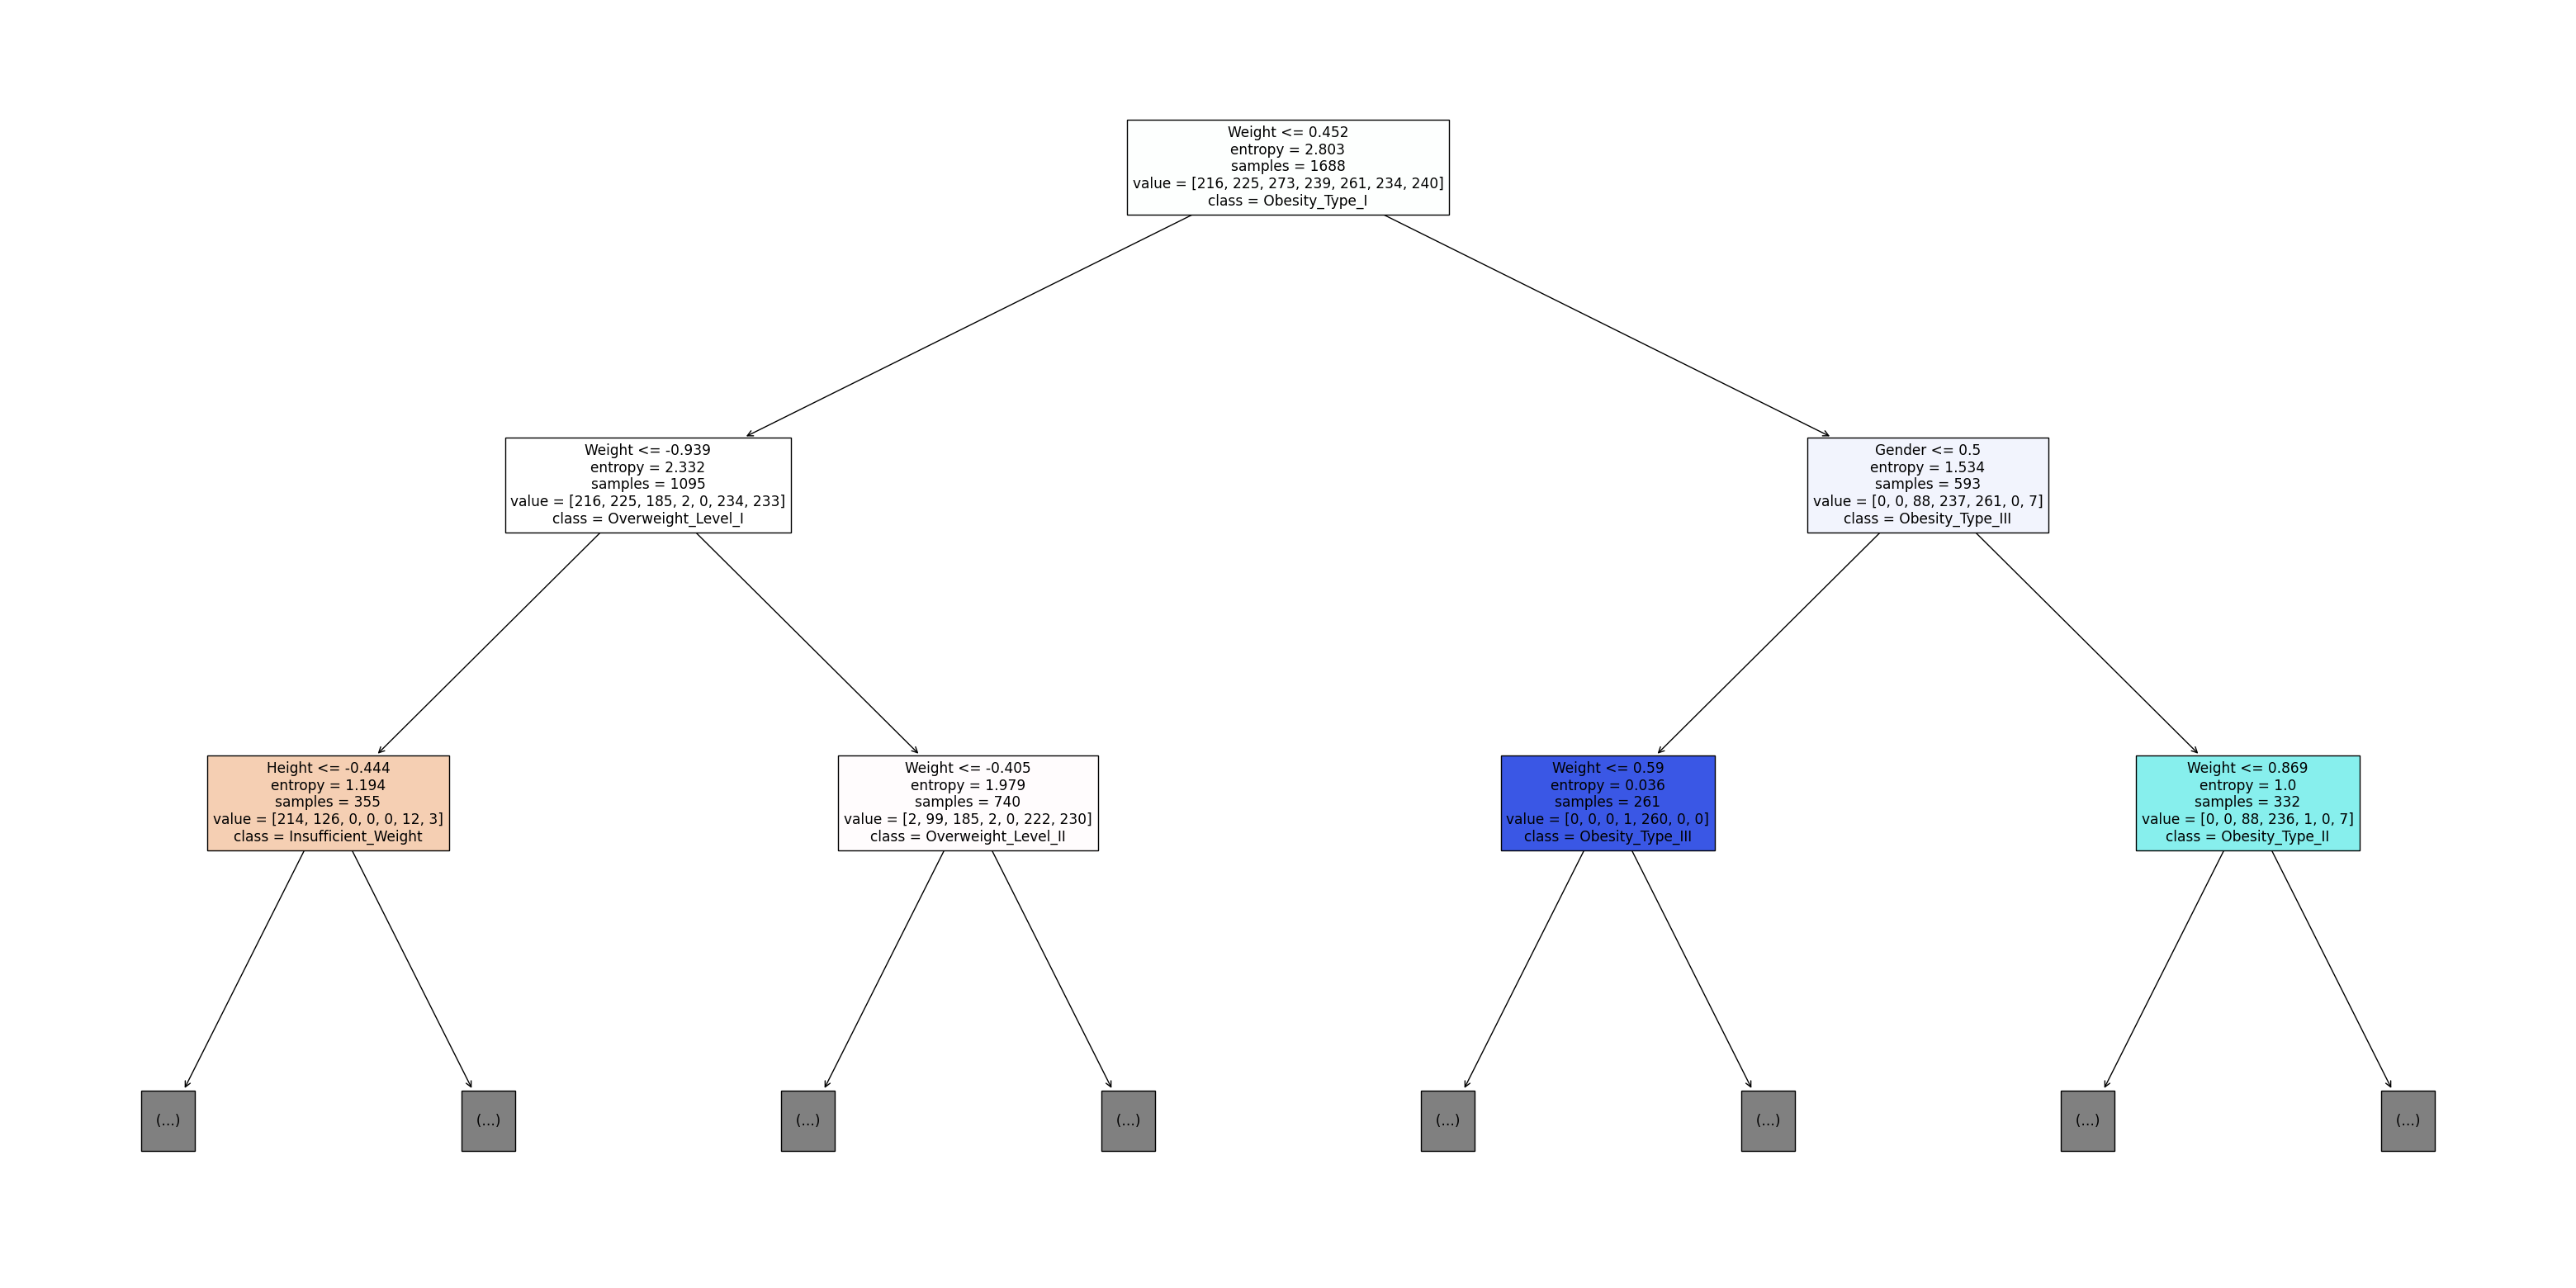

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(40,20))
plot_tree(best_model, feature_names=X.columns, class_names=label_encoder.classes_, filled=True, max_depth=2)
plt.show()

In [8]:
dot_data = export_graphviz(
    best_model, 
    out_file=None, 
    feature_names=X.columns, 
    class_names=label_encoder.classes_, 
    filled=True, 
    rounded=True, 
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Guarda el archivo como decision_tree.pdf
graph.view()

'decision_tree.pdf'

## Bone Marrow Transplant

In [9]:
dataRff = arff.loadarff('Bone_Marrow_Transplant/bone-marrow.arff')
df = pd.DataFrame(dataRff[0])
df.survival_status = df.survival_status.astype(int)

df.drop(columns='survival_time', inplace=True)


# Decodificar las columnas binarias o categóricas que están en bytes
for column in df.select_dtypes([object]).columns:
    # Convertir las columnas de bytes a strings (y opcionalmente a enteros si son 0/1)
    df[column] = df[column].str.decode('utf-8')  # Para texto
    if set(df[column].unique()).issubset({'0', '1'}):
        df[column] = df[column].astype(int)  # Convertir 0/1 a enteros

for i in range(len(df)):
    for col in df:
        if df[col].dtype == np.dtype('object'):
            if df.at[i, col] == '?':
                df.at[i, col] = np.nan
        else:
            if pd.isna(df.loc[i, col]):
                df.at[i, col] = np.nan

print(df.isna().sum().sum())
display(df)

81


,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,aGvHDIIIIV,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_status
0,1,1,22.830137,0,1,0,1,1,1,0,...,0,1,7.20,1.338760,5.38,35.0,19.0,51.0,32.0,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,1,1,4.50,11.078295,0.41,20.6,16.0,37.0,1000000.0,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,1,1,7.94,19.013230,0.42,23.4,23.0,20.0,1000000.0,1
3,0,0,39.684932,1,1,0,1,2,1,1,...,0,NaN,4.25,29.481647,0.14,50.0,23.0,29.0,19.0,1
4,0,1,33.358904,0,0,0,1,2,0,1,...,1,1,51.85,3.972255,13.05,9.0,14.0,14.0,1000000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1,0,0,...,0,1,11.08,2.522750,4.39,44.0,15.0,22.0,16.0,1
183,0,1,22.895890,0,0,0,1,0,1,1,...,1,1,4.64,1.038858,4.47,44.5,12.0,30.0,1000000.0,1
184,0,1,27.347945,0,1,0,1,-1,1,1,...,1,1,7.73,1.635559,4.73,33.0,16.0,16.0,1000000.0,0
185,1,1,27.780822,0,1,0,1,0,1,1,...,0,0,15.41,8.077770,1.91,24.0,13.0,14.0,54.0,1


In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separar en variables independientes (X) y dependiente (y)
X = df.drop(columns=['survival_status'])  # Reemplaza 'target' por la columna objetivo real
y = df['survival_status']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar columnas numéricas
NUMERIC_FEATURES = X_train.select_dtypes(include=['float64', 'int64']).columns

# Crear el pipeline para las columnas numéricas
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

# Ajustar el pipeline solo con los datos de entrenamiento
numeric_pipe.fit(X_train[NUMERIC_FEATURES])

# Transformar los datos de entrenamiento y prueba
X_train[NUMERIC_FEATURES] = numeric_pipe.transform(X_train[NUMERIC_FEATURES])
X_test[NUMERIC_FEATURES] = numeric_pipe.transform(X_test[NUMERIC_FEATURES])

# Entrenar el modelo de árbol de decisión
dtc = DecisionTreeClassifier(random_state=123)

# Definir los hiperparámetros para GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función de criterio
    'max_depth': range(2,11),  # Profundidad máxima del árbol
    'min_samples_split': range(2,11),  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': range(1,5)    # Mínimo de muestras en una hoja
}

# Crear GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=5,                # Número de divisiones para la validación cruzada
    verbose=1           # Mostrar progreso
)

start_time = time.time()
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Entrenamiento del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_


training_time = time.time() - start_time

# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

# Usar el mejor modelo encontrado por GridSearch
best_model = grid_search.best_estimator_


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tiempo de entrenamiento: 15.7668 segundos


In [11]:
# Hacer predicciones con el modelo optimizado
y_pred = best_model.predict(X_test)

# Evaluar el rendimiento del modelo optimizado
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy DecisionTree: ", round(accuracy_score(y_test, y_pred)*100,4))
print("ROC AUC:", np.round(roc_auc_score(y_test, y_pred)*100, 4))
print("PR AUC:", np.round(average_precision_score(y_test, y_pred)*100, 4))
print("F1-score:", np.round(f1_score(y_test, y_pred)*100, 4))
print("Precision:", np.round(precision_score(y_test, y_pred)*100, 4))
print("Recall:", np.round(recall_score(y_test, y_pred)*100, 4))


Confusion Matrix:
[[20  2]
 [ 8  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        22
           1       0.80      0.50      0.62        16

    accuracy                           0.74        38
   macro avg       0.76      0.70      0.71        38
weighted avg       0.75      0.74      0.72        38

Accuracy DecisionTree:  73.6842
ROC AUC: 70.4545
PR AUC: 61.0526
F1-score: 61.5385
Precision: 80.0
Recall: 50.0



Matriz de confusión:


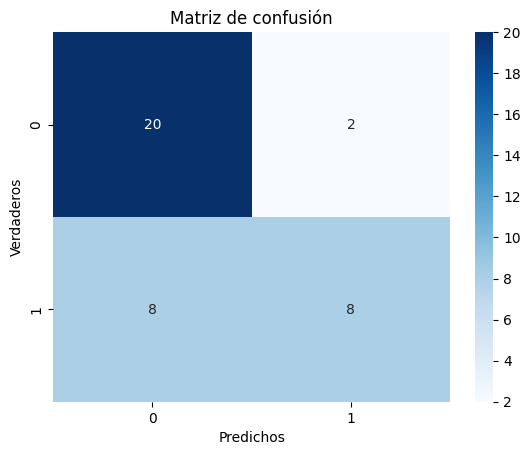

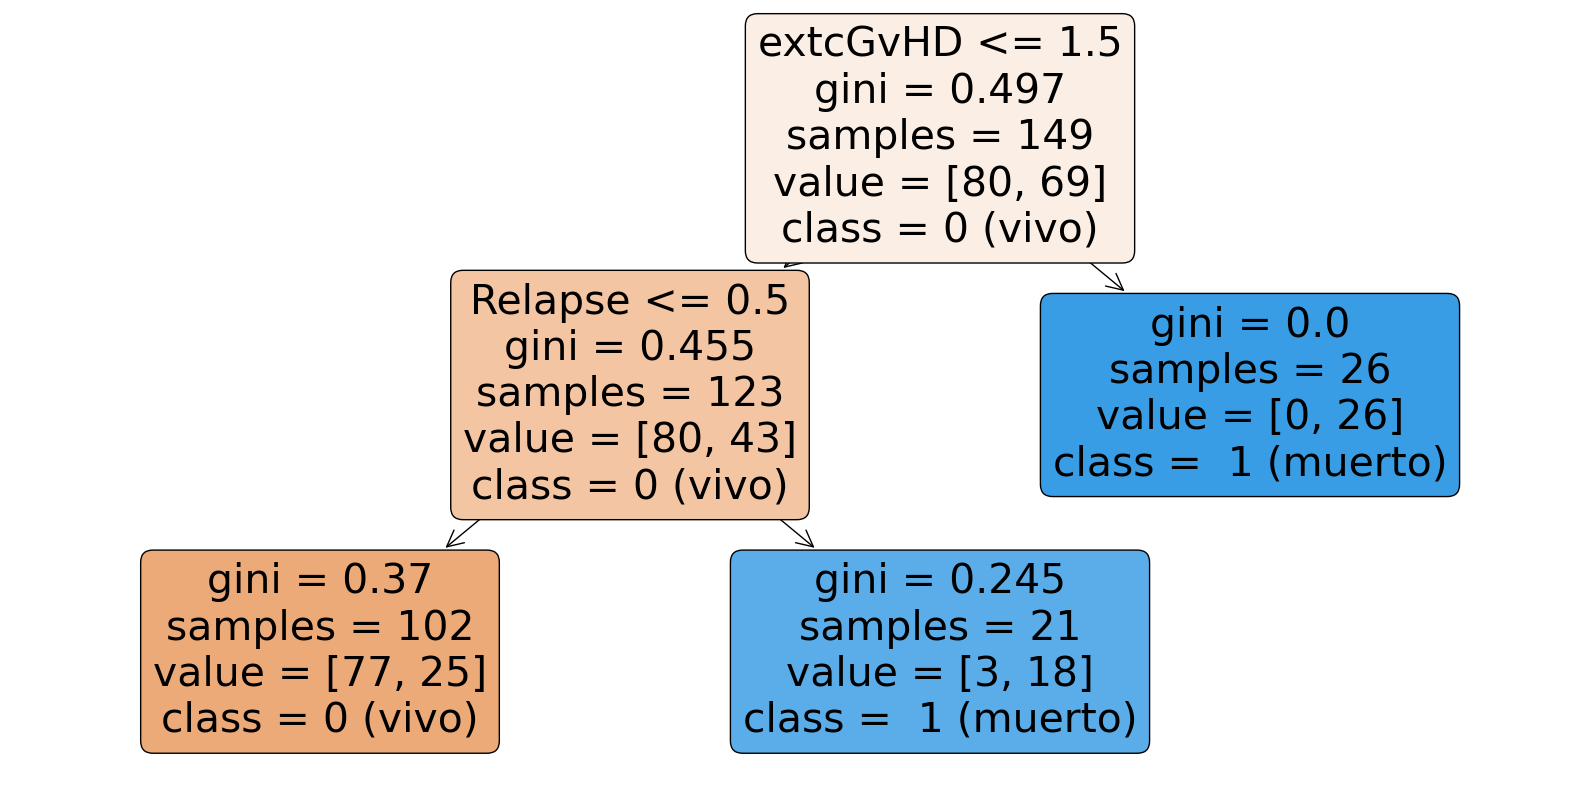

In [16]:
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.title('Matriz de confusión')
plt.show()


class_name = ['0 (vivo)', ' 1 (muerto)']

plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=X.columns, class_names=class_name,  filled=True, rounded=True)
plt.show()

## Chronic Kidney Disease

In [3]:
df = pd.read_csv('Chronic_Kidney_Disease/kidney_disease.csv', na_values='?')

df.drop(columns='id', inplace=True)

df = df.replace(r' ', '', regex=True)
df = df.replace(r'\t', '', regex=True)
for i in range(len(df)):
    for col in df:
        if df[col].dtype == np.dtype('object'):
            if df.at[i, col] == '?':
                df.at[i, col] = np.nan
        else:
            if pd.isna(df.loc[i, col]):
                df.at[i, col] = np.nan

display(df)
print("Valores faltantes: ",df.isna().sum().sum())

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51,7200,5.9,no,no,no,good,no,no,notckd


Valores faltantes:  1012


In [4]:
df['classification'] = df['classification'].map({'ckd': 0, 'notckd': 1})
cat_col=[col for col in df.columns if df[col].dtype =='object'] # categoric
num_col=[col for col in df.columns if df[col].dtype !='object'] # numeric

In [30]:
# # Supongamos que `df` es tu DataFrame y `num_col` contiene las columnas numéricas
# num_col = df.select_dtypes(include=['float64', 'int64']).columns  # Detectar columnas numéricas automáticamente

# # Crear el imputador usando la media como estrategia (puedes cambiarla a 'median' o 'most_frequent')
# imputer = SimpleImputer(strategy='mean')  # También puedes usar 'median' o 'most_frequent'

# # Ajustar el imputador a las columnas numéricas y transformar los datos
# df[num_col] = imputer.fit_transform(df[num_col])

# # Verificar si aún hay valores faltantes
# print(df[num_col].isna().sum())

age               0
bp                0
sg                0
al                0
su                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
classification    0
dtype: int64


In [5]:
def solve_mv_mode(feature):
    mode=df[feature].mode()[0]
    df[feature]=df[feature].fillna(mode)
    
for col in cat_col:
    solve_mv_mode(col)
df[cat_col].isna().sum()

rbc      0
pc       0
pcc      0
ba       0
pcv      0
wc       0
rc       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64

In [6]:
encoder=LabelEncoder()

for col in cat_col:
    df[col]=encoder.fit_transform(df[col])

In [7]:
x=df.drop('classification',axis=1)
y=df['classification']

X_train ,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=22)


# Identificar columnas numéricas
NUMERIC_FEATURES = X_train.select_dtypes(include=['float64', 'int64']).columns

# Crear el pipeline para las columnas numéricas
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

# Ajustar el pipeline solo con los datos de entrenamiento
numeric_pipe.fit(X_train[NUMERIC_FEATURES])

# Transformar los datos de entrenamiento y prueba
X_train[NUMERIC_FEATURES] = numeric_pipe.transform(X_train[NUMERIC_FEATURES])
X_test[NUMERIC_FEATURES] = numeric_pipe.transform(X_test[NUMERIC_FEATURES])

# Entrenar el modelo de árbol de decisión
dtc = DecisionTreeClassifier(random_state=123)

# Definir los hiperparámetros para GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función de criterio
    'max_depth': range(2,11),  # Profundidad máxima del árbol
    'min_samples_split': range(2,11),  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': range(1,5)    # Mínimo de muestras en una hoja
}

# Crear GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=5,                # Número de divisiones para la validación cruzada
    verbose=1           # Mostrar progreso
)

start_time = time.time()
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Entrenamiento del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_


training_time = time.time() - start_time

# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

# Usar el mejor modelo encontrado por GridSearch
best_model = grid_search.best_estimator_


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tiempo de entrenamiento: 25.2852 segundos


In [8]:
# Hacer predicciones con el modelo optimizado
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

print("Accuracy: ", round(accuracy_score(y_test, y_pred),4)*100)
print("ROC AUC:", np.round(roc_auc_score(y_test, y_pred), 4)*100)
print("PR AUC:", np.round(average_precision_score(y_test, y_pred), 4)*100)
print("F1-score:", np.round(f1_score(y_test, y_pred), 4)*100)
print("Precision:", np.round(precision_score(y_test, y_pred), 4)*100)
print("Recall:", np.round(recall_score(y_test, y_pred), 4)*100)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        51
           1       0.96      0.90      0.93        29

    accuracy                           0.95        80
   macro avg       0.95      0.94      0.95        80
weighted avg       0.95      0.95      0.95        80

Accuracy:  95.0
ROC AUC: 93.85
PR AUC: 90.08
F1-score: 92.86
Precision: 96.3
Recall: 89.66


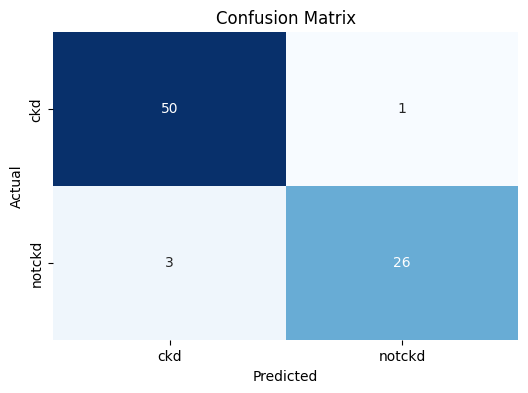

In [12]:
# Suponiendo que ya tienes cm calculado
cm = confusion_matrix(y_test, y_pred)

# Definir las etiquetas personalizadas
labels = ['ckd', 'notckd']

# Crear el heatmap con etiquetas personalizadas
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

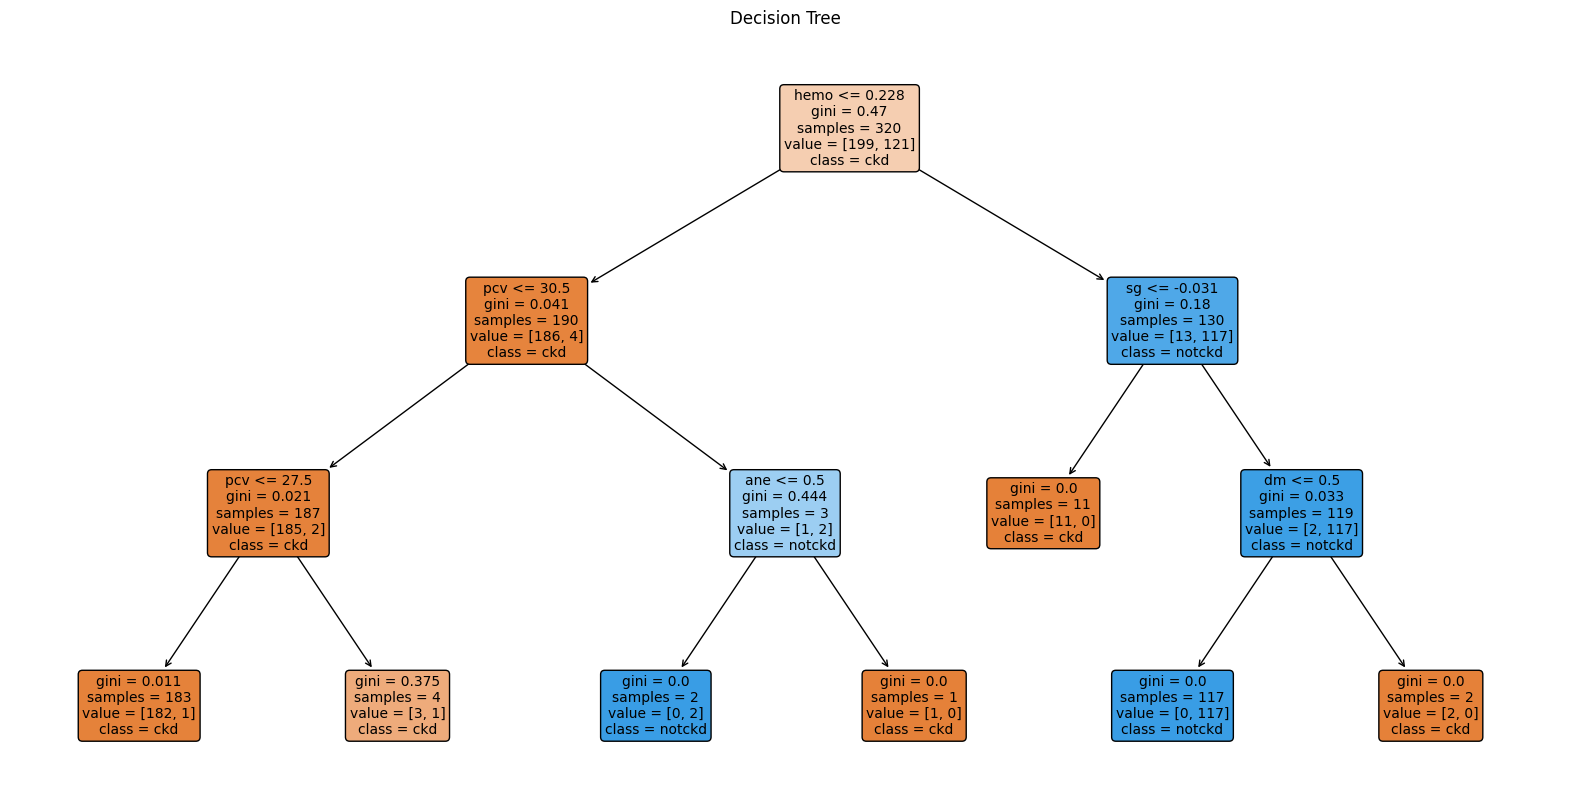

In [10]:
class_name = ['ckd', 'notckd']
feature_names = x.columns
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=feature_names, class_names=class_name, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree")
plt.show()

##  Diabetes 130-US Hospitals

In [18]:
df = pd.read_csv('Diabetes_130US/diabetic_data.csv')

df.loc[df['race'] == '?', 'race'] = 'Other'

df.drop(df[df['gender'] == 'Unknown/Invalid'].index, inplace = True)

df.reset_index(inplace = True, drop = True)

df.drop(columns = ['weight', 'payer_code', 'medical_specialty'], inplace = True)

df.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

df = df[~((df['diag_1'] == "?") | (df['diag_2'] == "?") | (df['diag_3'] == "?"))]

df = df.drop(columns= ['encounter_id', 'patient_nbr'])

df['readmitted']=df['readmitted'].apply(lambda x : 1 if x =='<30' or x == '>30' else 0)

#### Transform Categorical Features

In [19]:
categorical_features =['race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult'] 

le = LabelEncoder()
for i in categorical_features:
    df[i] = le.fit_transform(df[i])

In [20]:
X = df.drop(columns= ['readmitted'])
y = df['readmitted']

In [21]:
X_train ,X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=22)

# Identificar columnas numéricas
NUMERIC_FEATURES = X_train.select_dtypes(include=['float64', 'int64']).columns

# Crear el pipeline para las columnas numéricas
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

# Ajustar el pipeline solo con los datos de entrenamiento
numeric_pipe.fit(X_train[NUMERIC_FEATURES])

# Transformar los datos de entrenamiento y prueba
X_train[NUMERIC_FEATURES] = numeric_pipe.transform(X_train[NUMERIC_FEATURES])
X_test[NUMERIC_FEATURES] = numeric_pipe.transform(X_test[NUMERIC_FEATURES])

# Entrenar el modelo de árbol de decisión
dtc = DecisionTreeClassifier(random_state=123)

# Definir los hiperparámetros para GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función de criterio
    'max_depth': range(2,11),  # Profundidad máxima del árbol
    'min_samples_split': range(2,11),  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': range(1,5)    # Mínimo de muestras en una hoja
}

# Crear GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=5,                # Número de divisiones para la validación cruzada
    verbose=1           # Mostrar progreso
)

start_time = time.time()
print("\nIniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Entrenamiento del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_


training_time = time.time() - start_time

# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)
22 
# Usar el mejor modelo encontrado por GridSearch
best_model = grid_search.best_estimator_


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10}
Tiempo de entrenamiento: 1357.0079 segundos


In [22]:
y_pred = best_model.predict(X_test)
print("Accuracy: ", round(accuracy_score(y_test, y_pred),4)*100)
print("ROC AUC:", np.round(roc_auc_score(y_test, y_pred), 4)*100)
print("PR AUC:", np.round(average_precision_score(y_test, y_pred), 4)*100)
print("F1-score:", np.round(f1_score(y_test, y_pred), 4)*100)
print("Precision:", np.round(precision_score(y_test, y_pred), 4)*100)
print("Recall:", np.round(recall_score(y_test, y_pred), 4)*100)

Accuracy:  63.190000000000005
ROC AUC: 62.35000000000001
PR AUC: 54.269999999999996
F1-score: 56.47
Precision: 61.92999999999999
Recall: 51.89


Accuracy: 0.63

              precision    recall  f1-score   support

           0       0.64      0.73      0.68     10824
           1       0.62      0.52      0.56      9225

    accuracy                           0.63     20049
   macro avg       0.63      0.62      0.62     20049
weighted avg       0.63      0.63      0.63     20049



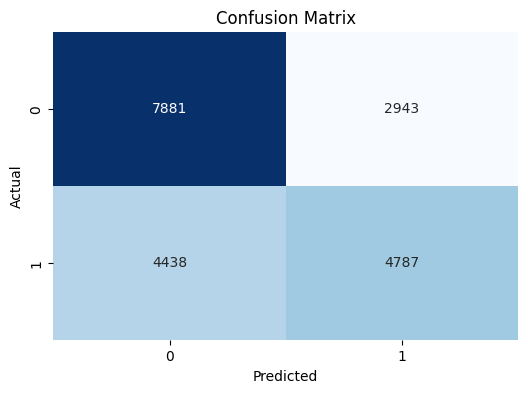

In [23]:
# Hacer predicciones con el modelo optimizado
dtc_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {dtc_acc:.2f}\n")
print(classification_report(y_test, y_pred))




# Suponiendo que ya tienes cm calculado
cm = confusion_matrix(y_test, y_pred)

# Definir las etiquetas personalizadas
labels = ['No readmitido', 'readmitido']

# Crear el heatmap con etiquetas personalizadas
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

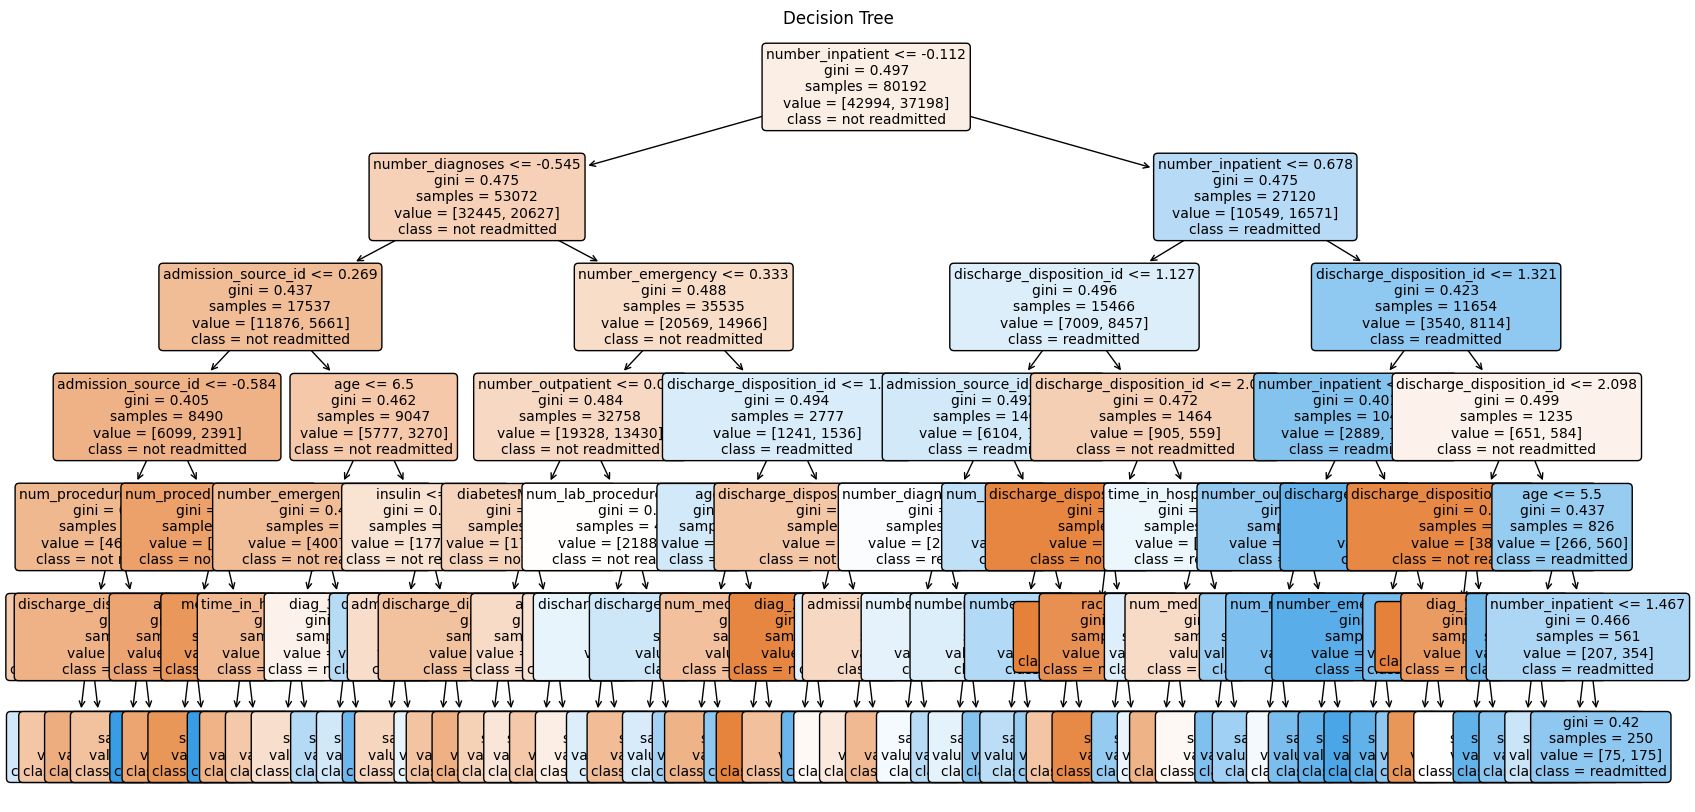

<Figure size 640x480 with 0 Axes>

In [25]:
class_name = ['not readmitted', 'readmitted']
feature_names = X.columns
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=feature_names, class_names=class_name, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree")
plt.show()

plt.savefig("DT_plot.png", dpi=600, bbox_inches='tight')